# Summary

Use this notebook to generate training data.
- (i) initialize an observer (with or without parallax)
- (ii) randomly sample sources and lenses relative to one another
- (iii) observe the source $N_O$ times, creating a list of celestial coordinates, $[\phi, \theta]_i$.
- (iv) repeat this process $N_t$ times

# Downloads

In [1]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
%autoreload

import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

# Astropy
from astropy import units as u

# lenstools
import lenstools as lt

# Convenient variables
pi   = np.pi
norm = np.linalg.norm
mult = np.matmul
dot  = np.dot

# Parameters

In [224]:
# Training set size
N_t = int(1e2)

In [225]:
# Observer properties

# Number of observations
N_o = 20

# Observation time
t_obs = 5 * u.yr

# Time increment for observations
dt = t_obs/N_o

# Flag to include parallax or not
#    observer moves along a cirlce of radius 1AU with period 1yr
parallax = True

In [226]:
# Lens properties

# mass parameter of lenses
M_l = 1e7 * u.M_sun

# kind of lens: ['point', 'Gaussian', 'tNFW', 'Burkert']
# Warning: Latter two not implemented yet
kind = 'Gaussian'

# Length scale of lens mass distribution
R_l = 1. * u.pc

# Length scale of observer-lens distance
D_ol = 1. * u.kpc

In [227]:
# Source properties

# Length scale of lens-source distance
D_ls = 1. * u.kpc

# Length scale of source impact parameter
D_b = 1. * u.kpc

In [228]:
# length scales will be used according to:
#    scale[0] -> uniform distribution of lens distance from observer
#    scale[1] -> uniform distribution of source distance past lens
#    scale[2] -> uniform distribution of source perp distance from 
#                observer-lens axis

scale = [D_ol, D_ls, D_b]

# Example: Lucky Event

Use a reference frame where $z$ is up-down, $x$ is left-right, and $y$ is distance in front or behind. 

So an object straight in front of you (the observer) has only a non-zero $y$ coordinate, and angular coordinates $\theta = \phi = \pi/2$, and $\phi$ will shrink if $x$ grows.

In [229]:
# Create an observer object
obs = lt.Observer(parallax = parallax)

# Create a Lens that is ~.1 kpc away, moves very fast along the
# x-axis, is in the x-y plane, and transits over the span of ~5 yrs
lucky_lens = lt.Lens(
    x = np.array([-.05, 100, 0]) * u.pc,
    v = np.array([2e4, 0, 0]) * u.km/u.s,
    kind=kind, M=M_l, R =R_l
) 

# The source is stationary, in the z-y plane, and has a small
# impact parameter (is slightly above the x-y plane)
lucky_src = lt.Source(
    x = np.array([0, 300, 10]) * u.pc,
    v = np.array([0, 0, 0]) * u.km/u.s
)

In [230]:
# Observe the source without any lensing
res_unlensed = obs.observe(lucky_src)

# Observe the source with lensing
res_lensed = obs.observe(lucky_src, lucky_lens)

# Compare lensed and unlensed observations
print('[d\\theta, d\phi]:',
      (res_lensed-res_unlensed).to(u.mas))

[d\theta, d\phi]: [2.62865406e+01 4.41717979e-03] mas


/usr/local/lib/python3.9/site-packages/astropy/units/quantity.py:614: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


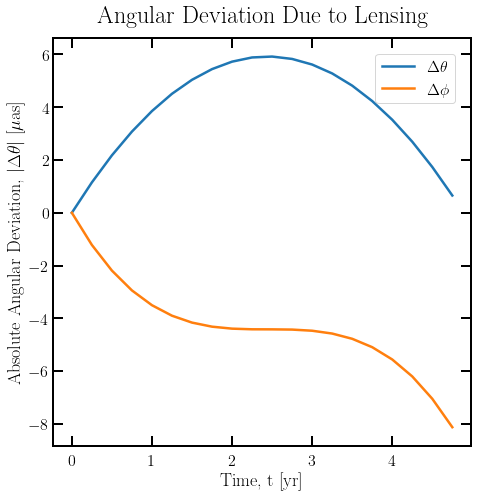

In [231]:
%autoreload
# Now observe multiple times
# Multi-measurements are defined such that \theta_0 and \phi_0
# are subtracted from the list of measurements
# The deviations between lensed/unlensed becomes smaller as a result

res_unlensed = obs.observe(lucky_src, N=N_o, dt=dt)
res_lensed = obs.observe(lucky_src, lucky_lens, N=N_o, dt=dt)

plt.figure(figsize=(7.5,7.5))
# plt.loglog()

times = np.arange(0, t_obs.value, dt.value) * dt.unit
res = np.array(res_lensed-res_unlensed)

plt.plot(times, res[:,0]*1e3, label=r'$\Delta \theta$')
plt.plot(times, res[:,1]*1e3, label=r'$\Delta \phi$')

plt.xlabel('Time, t [yr]')
plt.ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
plt.title('Angular Deviation Due to Lensing')
plt.legend()

# Example 2: Random Lens and Source

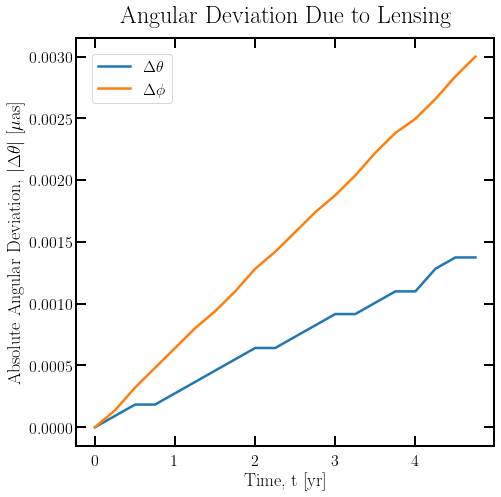

In [232]:
%autoreload
# Try generating a random lens-source pair
lens, src = lt.sample(
    'relative', scale=scale, observer=obs, kind=kind, M=M_l, R=R_l)

res_unlensed = obs.observe(src, N=N_o, dt=dt)
res_lensed = obs.observe(src, lens, N=N_o, dt=dt)

plt.figure(figsize=(7.5,7.5))
# plt.loglog()

times = np.arange(0, t_obs.value, dt.value) * dt.unit
res = np.array(res_lensed-res_unlensed)

plt.plot(times, res[:,0]*1e3, label=r'$\Delta \theta$')
plt.plot(times, res[:,1]*1e3, label=r'$\Delta \phi$')

plt.xlabel('Time, t [yr]')
plt.ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
plt.title('Angular Deviation Due to Lensing')
plt.legend()

# Generate Training Set

In [253]:
# All data in micro-arcseconds
Tset = np.zeros((N_t, N_o, 2))

# Set the impact parameter scale to something smaller to get 
# more of a signal
scale[2] = 10 * u.pc

# Progress bar
for i in tqdm(np.arange(N_t)):
    lens, src = lt.sample(
        'relative', scale=scale, observer=obs,
        kind=kind, M=M_l, R=R_l
    )
    
    res_unlensed = obs.observe(src, N=N_o, dt=dt)
    res_lensed = obs.observe(src, lens, N=N_o, dt=dt)

    Tset[i] = np.array(res_lensed-res_unlensed)

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_19445/3904005788.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(N_t)):


  0%|          | 0/100 [00:00<?, ?it/s]